In [244]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import pygad
import itertools
import random
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams["figure.figsize"] = (10, 7)

In [245]:
data = pd.read_excel("81_tech_stock.xlsx")
data

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2022-04-01,174.029999,174.880005,171.940002,174.309998,173.260437,78751300,AAPL
1,2022-04-04,174.570007,178.490005,174.440002,178.440002,177.365570,76468400,AAPL
2,2022-04-05,177.500000,178.300003,174.419998,175.059998,174.005920,73401800,AAPL
3,2022-04-06,172.360001,173.630005,170.130005,171.830002,170.795364,89058800,AAPL
4,2022-04-07,171.160004,173.360001,169.850006,172.139999,171.103485,77594700,AAPL
...,...,...,...,...,...,...,...,...
20732,2023-04-11,133.360001,134.889999,130.860001,131.279999,131.279999,912100,SPOT
20733,2023-04-12,133.089996,134.285004,130.440002,130.919998,130.919998,1117000,SPOT
20734,2023-04-13,132.399994,135.130005,132.210007,134.960007,134.960007,1120600,SPOT
20735,2023-04-14,134.029999,135.820007,132.770004,134.740005,134.740005,978800,SPOT


In [246]:
df = data.copy()
start_date = "2022-04-01"
end_date = "2023-04-18"
df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
#print(df)
df = df[["Symbol", "Date", "Close"]].rename(columns={"Close": "price"}).reset_index(drop=True)
tickers = df["Symbol"].unique()

tickers_map = {i : j for i,j in zip(tickers, range(len(tickers)))}
print(len(tickers_map))
tickers_map_reverse = {j : i for i,j in zip(tickers, range(len(tickers)))}
# print(tickers_map_reverse)
df["ticker_index"]  = df["Symbol"].map(tickers_map)
firsts = (df.groupby('Symbol').transform('first'))
df["adj_price"] = df["price"] / firsts["price"]
df = df[["Symbol", "ticker_index", "Date", "adj_price"]]


80


In [247]:
df.groupby("Symbol").count().sort_values("Date")

,ticker_index,Date,adj_price
Symbol,,,
MBLY,118,118,118
QCOM,261,261,261
PYPL,261,261,261
PDD,261,261,261
PANW,261,261,261
...,...,...,...
DELL,261,261,261
CSGP,261,261,261
CSCO,261,261,261


#### Genetic algorithm

Below we try to find the best combination of 10 stocks that give the best return over the defined time period

In [254]:
## Define fitness function and utils

def portfolio_generate(df, tickers):
    portfolio = df[df['ticker_index'].isin(tickers)]
    portfolio = portfolio.groupby("Date", as_index=False).sum(numeric_only=True)
    portfolio = portfolio.sort_values("Date")
    return portfolio


def portfolio_return(portfolio):
    first_price = portfolio["adj_price"].iloc[0]
    last_price = portfolio["adj_price"].iloc[-1]
    # print(f"last_price / first_price - 1: {last_price / first_price - 1}")
    return last_price / first_price - 1

def portfolio_risk(portfolio):
    portfolio["daily_change"] = portfolio["adj_price"].diff(1)
    portfolio["daily_change"] = portfolio["daily_change"] / portfolio["adj_price"]
    # print("\n\ndaily_change: ", portfolio["daily_change"])
    # print("\n\nadj_price: ",portfolio["adj_price"])
    return portfolio["daily_change"].std()

def fitness_func(ga_instance, solution, solution_idx):
    # Penalize chromosomes with duplicate genes
    if len(set(solution)) != len(solution):
        return -1

    portfolio = portfolio_generate(df, solution)
    ret = portfolio_return(portfolio)
    ris = portfolio_risk(portfolio)
    fitness = ret / ris
    return fitness


def visualize(df, solution):
    solution_fitness = fitness_func(None, solution, None)
    portfolio  = portfolio_generate(df, solution)
    portfolio["adj_price"] = (portfolio["adj_price"] / portfolio["adj_price"].iloc[0] ) * 100
    ax = portfolio.plot.line(x="Date", y="adj_price")
    ax.set_ylim(60, 200)
    ret = round(portfolio_return(portfolio) * 100, 1)
    ris = round(portfolio_risk(portfolio) * 100, 1)
    
    print(f"Parameters of the best solution : {[tickers_map_reverse[i] for i in solution]}")
    print(f"Return: {ret}%")
    print(f"Risk: {ris}%")
    print(f"Risk adjusted return = {round(solution_fitness,1)}%")


In [249]:
fitness_function = fitness_func

num_generations = 50      # Increased to explore more solutions
num_genes = 5

sol_per_pop = 60          # Increased to encourage diversity in the population
num_parents_mating = 30    # Increased for more parent contributions

init_range_low = 0
init_range_high = 79      # Updated to match the number of tickers (80 - 1, since indexing starts from 0)
gene_type = int

parent_selection_type = "rank"   # Changed to 'rank' for a selection method based on relative fitness
keep_parents = 6                 # Increased to retain more parents in the next generation

crossover_type = "uniform"       # Changed to 'uniform' for more diversity in offspring

mutation_type = "random"
mutation_percent_genes = 20      # Reduced to slightly decrease the degree of mutation


In [250]:
## Initiate and run genetic algorithm

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       allow_duplicate_genes=False,
                       random_seed=2)
ga_instance.run()
for i,j in zip (ga_instance.best_solutions, ga_instance.best_solutions_fitness):
  print([(tickers_map_reverse[k],k) for k in sorted(i)],j)

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:222: UserWarning: You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.
  if not self.suppress_warnings: warnings.warn("You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.")
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 4 whose value is 3. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or ra

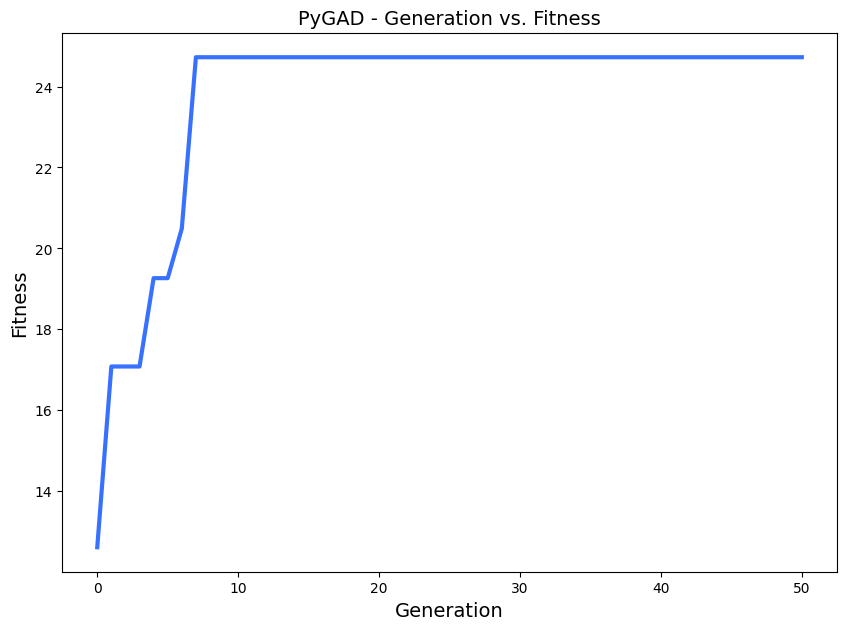

Parameters of the best solution : ['MBLY', 'ATVI', 'ON', 'IBM', 'CDNS']
Return: 54.2%
Risk: 2.2%
Risk adjusted return = 24.7%


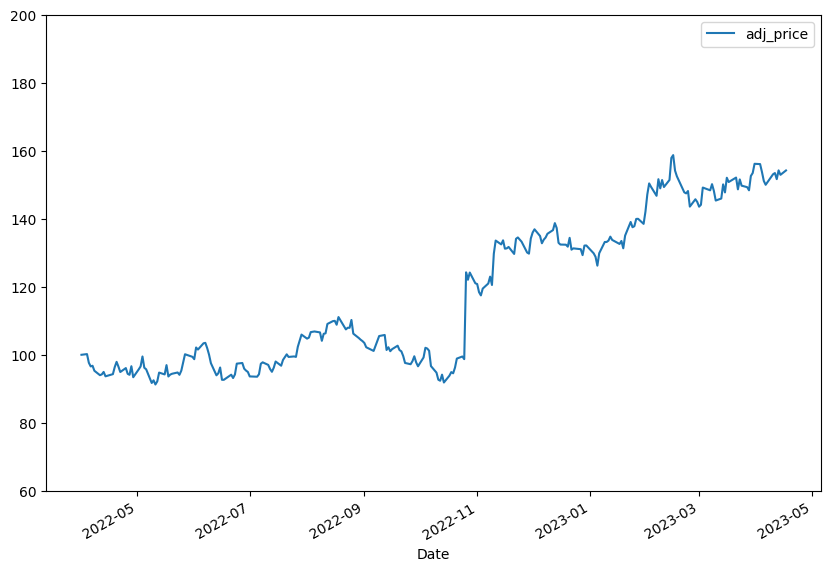

In [257]:
## Plot training, best resuls

ga_instance.plot_fitness(save_dir=None)
[solution, _, __] = ga_instance.best_solution()
visualize(df, solution)

Parameters of the best solution : ['PDD', 'MBLY', 'ON', 'CDNS', 'STM']
Return: 73.1%
Risk: 3.1%
Risk adjusted return = 23.6%


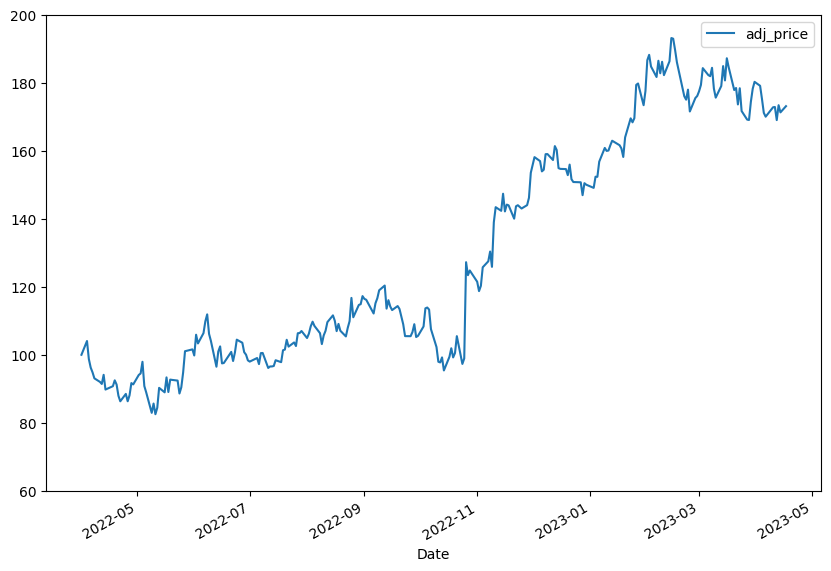

In [255]:
## Top 10 performers benchmark

firsts = df.groupby("ticker_index", as_index=False).first()
firsts = firsts.rename({"adj_price": "first_price"}, axis=1)[["ticker_index", "first_price"]]
lasts = df.groupby("ticker_index", as_index=False).last()
lasts = lasts.rename({"adj_price": "last_price"}, axis=1)[["ticker_index", "last_price"]]

df_ = firsts.merge(lasts, on="ticker_index", how="left")
df_["return"] = df_["last_price"] / df_["first_price"]
df_ = df_.sort_values("return", ascending=False)
best_return = df_.head(5)["ticker_index"].unique()

visualize(df, best_return)

Parameters of the best solution : ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'TSM', 'TCEHY', 'AVGO', 'ASML', 'BABA', 'CRM', 'CSCO', 'ADBE', 'SAP', 'TXN', 'NFLX', 'AMD', 'INTC', 'QCOM', 'INTU', 'IBM', 'SONY', 'BKNG', 'AMAT', 'NOW', 'ADP', 'ADI', 'PDD', 'PYPL', 'FISV', 'ABNB', 'LRCX', 'MU', 'EQIX', 'MELI', 'UBER', 'SHOP', 'ATVI', 'NTES', 'CDNS', 'SNPS', 'JD', 'PANW', 'VMW', 'KLAC', 'FTNT', 'ANET', 'ROP', 'WDAY', 'SNOW', 'SE', 'NXPI', 'BIDU', 'ADSK', 'STM', 'MCHP', 'TEL', 'TEAM', 'SQ', 'IQV', 'EA', 'FIS', 'XIACF', 'MRVL', 'GFS', 'DELL', 'CSGP', 'ON', 'MBLY', 'GPN', 'CPNG', 'TTD', 'HPQ', 'CRWD', 'VEEV', 'ANSS', 'KEYS', 'SPOT']
Return: -7.0%
Risk: 2.1%
Risk adjusted return = -3.3%


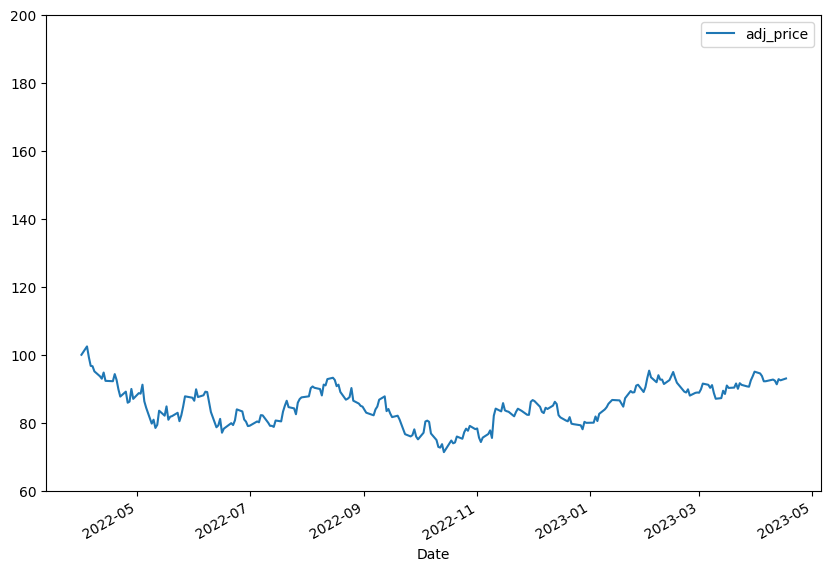

In [256]:
## S&P 500 benchmark

visualize(df, df["ticker_index"].unique())